In [1]:
import numpy as np
import h5py
import os
from tqdm.notebook import tqdm
import copy
import matplotlib.pyplot as plt
from pde import MemoryStorage

from methods.base import BaseConfig
from methods.plotting import plot_perm, plot_press, plot_seismic_dens
from methods.pore_press_calc_functions import Pore_Press_Diffusion_with_Q_source, test_wells, applying_factors

In [2]:
# setup base params
base_params = BaseConfig(
            sources = [{'loc':(2000, 2000, 2000), 'Q':np.array([1, 1]), 'P': 0.2}, # P - target overpressue relative to P0 (if p0=0.1 MPa, P=-0.05 => abs pressure = 0.1 - 0.05 = 0.05 MPa)
                       {'loc':(500, 500, 2000), 'Q':np.array([-0.25, -0.25]), 'P': -0.05},
                       {'loc':(3500, 500, 2000), 'Q':np.array([-0.25, -0.25]), 'P': -0.05},
                       {'loc':(3500, 3500, 2000), 'Q':np.array([-0.25, -0.25]), 'P': -0.05},
                       {'loc':(500, 3500, 2000), 'Q':np.array([-0.25, -0.25]), 'P': -0.05},],
            time_scale=3600, 
            t_range=240,
            NSAMPL = 200
            )

# wells testing if needed
# press_in_locs, interpolators = test_wells(copy.deepcopy(base_params))

In [3]:
from datetime import datetime
target_path = f'target_{datetime.now().strftime("%m_%d_%Y__%H_%M_%S")}.h5'

In [4]:
perms_path = 'downscaled_models_03_05_2024__13_33_23.h5'

with h5py.File(perms_path, 'r') as f:
    nmodels = f['perm'].shape[0]

# eq initial setup
eq = Pore_Press_Diffusion_with_Q_source(np.ones(base_params.shape), base_params)
p0 = eq.pore_ini_field

# idx_list = range(nmodels)
idx_list = [5,]
for ii in tqdm(idx_list):
    with h5py.File(perms_path, 'r') as f:
        perm = f['perm'][ii]
        dens = f['dens'][ii]
    
    eq.perm = perm # updating eq with new perm
    eq.xi_field = eq.get_xi_field()
    params = applying_factors(perm, copy.deepcopy(base_params))
    storage = MemoryStorage()
    res = eq.solve(p0, t_range=params.t_range, solver='scipy', tracker=[storage.tracker(1)])
    # res = eq.solve(p0, t_range=params.t_range, solver='scipy', tracker=['progress', 'plot', storage.tracker(1)])
    pore_press = np.stack(storage.data, axis=0) # 4d np array

  0%|          | 0/1 [00:00<?, ?it/s]

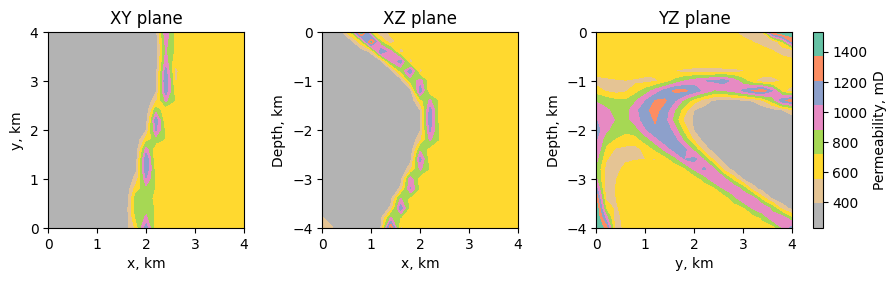

In [4]:
plot_perm(perm, (10, 10, 10), params)

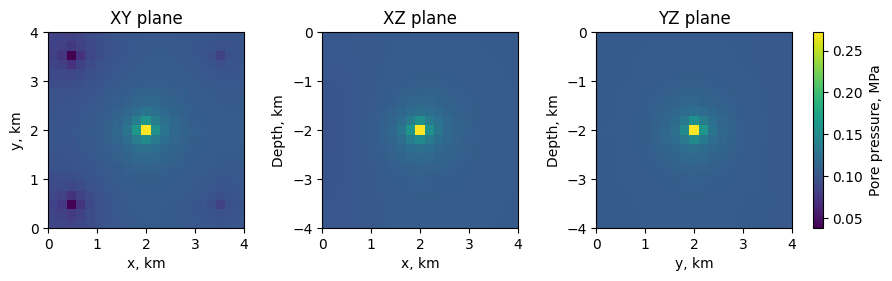

In [5]:
plot_press(pore_press[-1], (10, 10, 10), params)

In [248]:
# to event calc funcs
from scipy import stats
from numpy.polynomial import polynomial as P

class Micro_Seismic_Seeds():
    def __init__(self, params, **kwargs):
        self.params = params
        self.NSAMPL = self.params.NSAMPL

        # some custom defaults
        self.azi = np.pi/4 * np.ones(self.params.shape) #  average azimuth of fractures
        self.azi_sigma = np.pi*5/180 * np.ones(self.params.shape) # its std 

        self.dip = np.pi/2 * np.ones(self.params.shape) # dip: vertical fractires
        self.dip_sigma = np.pi*5/180 * np.ones(self.params.shape) # its std 

        self.tan_phi = 0.83 * np.ones(self.params.shape) # mean value of the friction coefficient (tan phi)
        self.tan_phi_sigma = 0.025 * self.tan_phi  # its std 

        self.C =  0.1 * np.ones(self.params.shape) # cohesion, MPa
        self.C_sigma = 0.03 * self.C # its std 

        self.__dict__.update(kwargs) # updating while init with custom parameters
        self.get_seed_network() # creating seed network

    def get_norm_vector(self, azi, dip):
        '''
        azi, dip: np.array
        Function for converting crack azimuth and dip to normal vector
        Azimuth is considered to be the angle of the crack direction in the XY plane (0 - 180 degrees) from the X-axis.
        Dip is the angle of dipination relative to the horizontal (0 - 90 degrees, 0 - horizontal crack).

        Функция для перевода азимута и наклона трещины трещины в вектор нормали
        Азимутом будем считать угол направления трещины в плоскости ХY (0 - 180 градусов) от оси X,
        Наклоном - угол наклона относительно горизонтали (0 - 90 градусов, 0 - горизонтальная трещина)
        '''
        nx = np.cos(np.pi/2 + azi) * np.cos(np.pi/2 + dip)
        ny = np.sin(np.pi/2 + azi) * np.cos(np.pi/2 + dip)
        nd = np.sin(np.pi/2 + dip)
        return np.stack((nx, ny, nd), axis=-1)

    def get_seed_network(self):
        # Parameter distribution laws (distribution parameters - arrays with model dimensionality)
        tan_phi_distrib = stats.weibull_min(loc=self.tan_phi, scale=self.tan_phi_sigma, c=1.8) # weibull distribution с=1.8
        C_distrib = stats.weibull_min(loc=self.C, scale=self.C_sigma, c=1.8) # weibull distribution с=1.8
        azi_distrib = stats.norm(loc=self.azi, scale=self.azi_sigma) # norm distribution
        dip_distrib = stats.norm(loc=self.dip, scale=self.dip_sigma)

        # Sampling NSAMPL values
        tan_phi_rvs = tan_phi_distrib.rvs(size=(self.NSAMPL,) + self.params.shape).astype('float16')
        C_rvs = C_distrib.rvs(size=(self.NSAMPL,) + self.params.shape).astype('float16')
        azi_rvs = azi_distrib.rvs(size=(self.NSAMPL,) + self.params.shape).astype('float16')
        dip_rvs = dip_distrib.rvs(size=(self.NSAMPL,) + self.params.shape).astype('float16')

        # Transpose so that the dimension is as needed: (model sahpe, NSAMPL)
        tan_phi_rvs = np.moveaxis(tan_phi_rvs, 0, -1)
        C_rvs = np.moveaxis(C_rvs, 0, -1)
        azi_rvs = np.moveaxis(azi_rvs, 0, -1)
        dip_rvs = np.moveaxis(dip_rvs, 0, -1)

        # converting fracture orientation angles to normal vectors
        norms_rvs = self.get_norm_vector(azi_rvs, dip_rvs) 

        # updating attributes
        self.tan_phi_rvs = tan_phi_rvs
        self.C_rvs = C_rvs
        self.norms_rvs = norms_rvs

        return  tan_phi_rvs, C_rvs, norms_rvs 
    
def get_litostat_pressure(params, ro):
    # ro [g/cm3] can be either an array of the model's shape or a value.
    dz = params.dx_dy_dz[-1]
    ro_arr = np.ones(params.shape) * ro * 1e3 # kg/m3
    litho_press_incr = ro_arr * dz * 1e-5 # MPa increment
    litho_press = np.cumsum(litho_press_incr, axis=2) - litho_press_incr / 2 # mean lithostatic pressure in cell
    return litho_press

def get_stress(params, lithostat_pressure):    
    '''
    calculates the stress tensor using Dinnik's formula
    '''
    poisson = params.poisson
    poisson_const = poisson/(1-poisson)
    point_tens = np.diag((poisson_const, poisson_const, 1)).astype('float16')
    stress_tensor = np.expand_dims((lithostat_pressure),(-2,-1)) * point_tens # (x,y,d,3,3)
    return stress_tensor

def get_norm_and_shear_stress_on_seeds(tens, norms):
    '''
    calculates normal and shear stresses on planes with orientations defined by normal vectors
    '''
    vect = (np.expand_dims(tens,-3) @ np.expand_dims(norms,-1)).squeeze(-1)
    sigma_n = (np.expand_dims(vect,-2) @ np.expand_dims(norms,-1)).squeeze(-1) # normal stresses

    vect2 = (np.expand_dims(vect, -2) @ np.expand_dims(vect, -1)).squeeze(-1) # power 2
    sigma_n2 = sigma_n**2

    tau = np.sqrt(np.abs(vect2 - sigma_n2)) # shear stresses

    sigma_n = sigma_n.squeeze(-1) # (x,y,d,NSAMPL)
    tau = tau.squeeze(-1) # (x,y,d,NSAMPL)
    return sigma_n, tau

def check_colomb_criteria(params, pore_press, tan_phi, C, sigma_n, tau):
    '''
    Делаем распределение критерия Кулона F = tau - (sigma_n - pore) * tg_phi - C
    Вероятность события - это процент семплированных значений, больших нуля.
    '''
    pore = np.expand_dims(pore_press, -1) # it needs one more dimensions for broadcasting (x,y,d,1)
    alpha = params.alpha # Bioе coefficient
    F = tau - (sigma_n - alpha * pore) * tan_phi - C
    colomb_pass = np.sum(F>0, axis=-1) # number of seeds for which the coulomb criterion was met
    return colomb_pass

def get_raw_events(params, colomb_pass):
    events_diff = np.diff(colomb_pass, axis=0).astype('float') # increment at each step in the number of seeds for which the Coulomb criterion is met (t,x,y,d)
    events_diff[events_diff<0] = 0 # positive change only 
    return events_diff

def resample_raw_events(params, raw_events):
    sampling_factor = params.target_events_num / np.sum(raw_events) # resampling the number of events to satisfy the total number of events
    return raw_events * sampling_factor

def get_events(params, events_dens):
    frac, integ = np.modf(events_dens)
    events  = integ + (np.random.rand(*events_dens.shape)<=frac)
    return events.astype('int')

def get_GR_params(mags, nbins=100):
    '''
    mags: list of magnitudes
    a, b: G-R law parameters
    '''
    m = np.sort(mags)
    bins = np.linspace(min(m), max(m), nbins) # bins
    N = np.array([np.sum(m>=b) for b in bins])
    a, b = P.polyfit(bins, np.log10(N), deg=1)
    return a, b

def get_magnetude(size, M_min=-1, b=1):
    '''
    magnitude sampling using min magnitude and b-value
    https://doi.org/10.1007/s11069-017-2750-5
    ev - 
    '''
    return stats.expon.rvs(size=size, loc=M_min, scale=1/(b*np.log(10)))

def get_events_list(ev_matrix):
    '''
    converts events sparse matrix to [[time,x,y,d,M],...] formаt
    '''
    ev_txyd = np.array(np.nonzero(ev_matrix)).T
    ev_num = np.array([ev_matrix[*ev_txyd[ii]] for ii in range(ev_txyd.shape[0])])
    ev = np.repeat(ev_txyd, ev_num, axis=0)
    mag = get_magnetude(ev.shape[0], M_min=0, b=1)
    return np.column_stack((ev, mag))


In [269]:
params = base_params # for testing

seeds = Micro_Seismic_Seeds(params) # creating microseismic seeds obj
tan_phi, C, norms = seeds.tan_phi_rvs, seeds.C_rvs, seeds.norms_rvs

lithostat_pressure = get_litostat_pressure(params, dens) 
hydrostat_pressure = get_litostat_pressure(params, params.ro) 

true_pore_press = pore_press + hydrostat_pressure # true pore pressure (dim broadcasting) 
stress = get_stress(params, lithostat_pressure) # litostatic stress tensor based on density model
sigma_n, tau = get_norm_and_shear_stress_on_seeds(stress, norms) # stresses without pore pressure

colomb_pass = check_colomb_criteria(params, true_pore_press, tan_phi, C, sigma_n, tau) # (dim broadcasting) 

raw_events = get_raw_events(params, colomb_pass) # num of seeds in every cell
events_dens = resample_raw_events(params, raw_events) # event probability (raw_events normalized to target num)
events = get_events(params, events_dens) # events

events_list = get_events_list(events) # list of events (time, x, y, d, Mag)

events_by_time = np.sum(events, axis=(1,2,3)) # events number at every step
tot_events = np.sum(events)

(1048, 5)

In [339]:
import matplotlib as mpl

def plot_events_slice(data, loc, params, vmin_vmax=None, save=False, fname='seism_dens'):
    cmap = mpl.cm.Set2_r
    if vmin_vmax is None:
        norm = mpl.colors.Normalize(vmin=np.min(data), vmax=np.max(data))
    else:
        norm = mpl.colors.LogNorm(vmin=vmin_vmax[0], vmax=vmin_vmax[1])

    x_ax, y_ax, z_ax = (np.linspace(0, sl, sh)/1000 for sh, sl in zip(params.shape, params.side_lenght))  # km

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
    plt.subplots_adjust(wspace=0.4,hspace=0.1)
    # fig.suptitle('seismic dens')

    ax1.contourf(x_ax, y_ax, data[:, :, loc[2]].transpose(), cmap=cmap, norm=norm, levels=100)
    ax1.set_title('XY plane')
    ax1.set_aspect('equal')
    ax1.set_xlabel('x, km')
    ax1.set_ylabel('y, km')

    ax2.contourf(x_ax, -z_ax, data[:, loc[1], :].transpose(),  cmap=cmap, norm=norm, levels=100)
    ax2.set_title('XZ plane')
    ax2.set_aspect('equal')
    ax2.set_xlabel('x, km')
    ax2.set_ylabel('Depth, km')

    ax3.contourf(y_ax, -z_ax, data[loc[0], :, :].transpose(),  cmap=cmap, norm=norm, levels=100)
    ax3.set_title('YZ plane')
    ax3.set_aspect('equal')
    ax3.set_xlabel('y, km')
    ax3.set_ylabel('Depth, km')

    # колорбар
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
              ax=(ax1, ax2, ax3), anchor=(-0.2, 0.5), shrink=0.85, orientation='vertical', label='Seismic density')

    if save:
        plt.savefig(f'{fname}.png', dpi = 300,  bbox_inches='tight', transparent=False)

    plt.show()


def plot_events_projection(data, params, vmin_vmax=None, save=False, fname='seism_dens'):
    cmap = mpl.cm.Set2_r
    if vmin_vmax is None:
        norm = mpl.colors.Normalize(vmin=np.min(data), vmax=np.max(data))
    else:
        norm = mpl.colors.LogNorm(vmin=vmin_vmax[0], vmax=vmin_vmax[1])

    x_ax, y_ax, z_ax = (np.linspace(0, sl, sh)/1000 for sh, sl in zip(params.shape, params.side_lenght))  # km

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
    plt.subplots_adjust(wspace=0.4,hspace=0.1)
    # fig.suptitle('seismic dens')

    ax1.contourf(x_ax, y_ax, np.sum(data, axis=2).transpose(), cmap=cmap, norm=norm, levels=100)
    ax1.set_title('XY plane')
    ax1.set_aspect('equal')
    ax1.set_xlabel('x, km')
    ax1.set_ylabel('y, km')

    ax2.contourf(x_ax, -z_ax, np.sum(data, axis=1).transpose(),  cmap=cmap, norm=norm, levels=100)
    ax2.set_title('XZ plane')
    ax2.set_aspect('equal')
    ax2.set_xlabel('x, km')
    ax2.set_ylabel('Depth, km')

    ax3.contourf(y_ax, -z_ax, np.sum(data, axis=0).transpose(),  cmap=cmap, norm=norm, levels=100)
    ax3.set_title('YZ plane')
    ax3.set_aspect('equal')
    ax3.set_xlabel('y, km')
    ax3.set_ylabel('Depth, km')

    # колорбар
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
              ax=(ax1, ax2, ax3), anchor=(-0.2, 0.5), shrink=0.85, orientation='vertical', label='Seismic density')

    if save:
        plt.savefig(f'{fname}.png', dpi=300,  bbox_inches='tight', transparent=False)

    plt.show()

def plot_event_list(ev_list, params):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    norm = mpl.colors.Normalize(vmin=np.min(ev_list[:,-1]), vmax=np.max(ev_list[:,-1]))
    cmap = mpl.cm.viridis_r
    t, x, y, d, M = [ev_list[:, ii] for ii in range(ev_list.shape[-1])]
    x_km, y_km, d_km = [dxdydz * xyz / 1000 for dxdydz, xyz in zip(params.dx_dy_dz, [x, y, -d])]
    ax.scatter(x_km, y_km, d_km, marker='o', c=t, cmap=cmap, norm=norm, s=100*M)
    # ax.set_aspect('equal')
    ax.set_xlabel('x, km')
    ax.set_ylabel('y, km')
    ax.set_zlabel('Depth, km')
    ax.set_xlim([0, params.side_lenght[0]/1000])
    ax.set_ylim([0, params.side_lenght[1]/1000])
    ax.set_zlim([-params.side_lenght[2]/1000, 0])


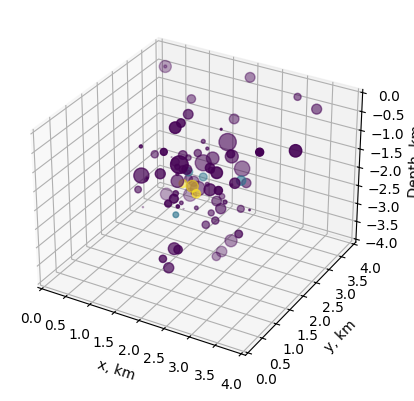

In [340]:
plot_event_list(events_list[0:90], params)

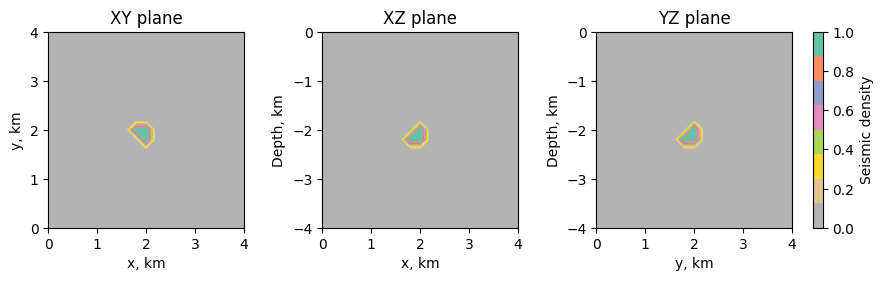

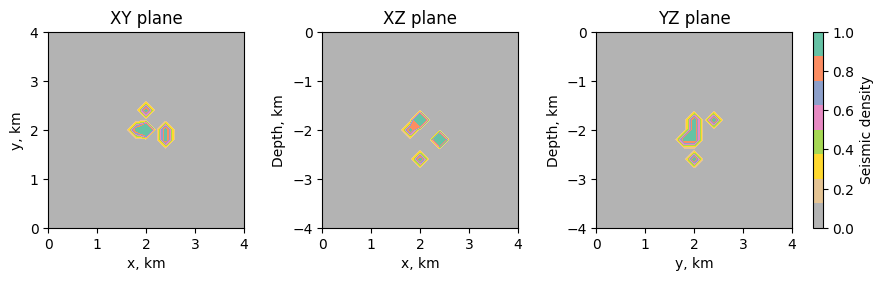

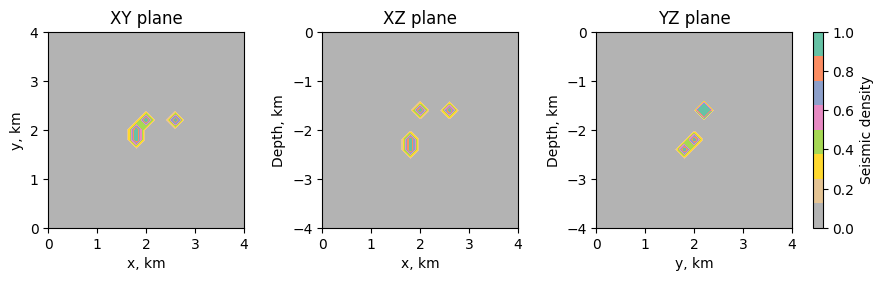

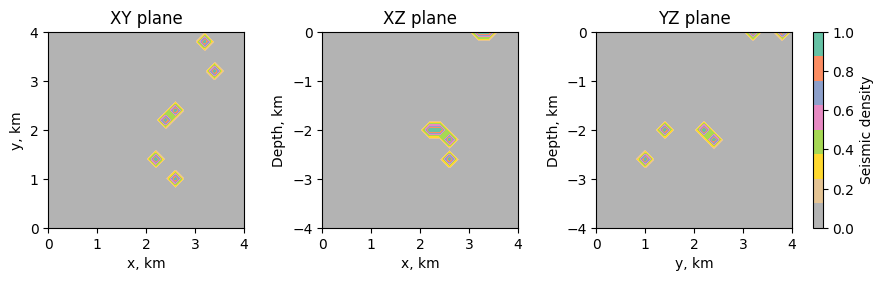

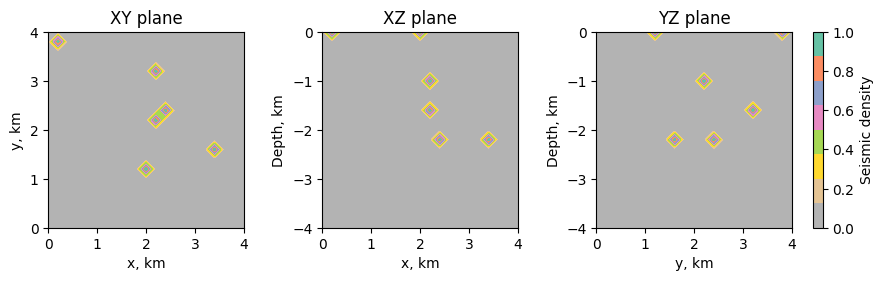

In [8]:
for ii in [0,1,2,5,10]:
    plot_events_projection(events[ii], params)

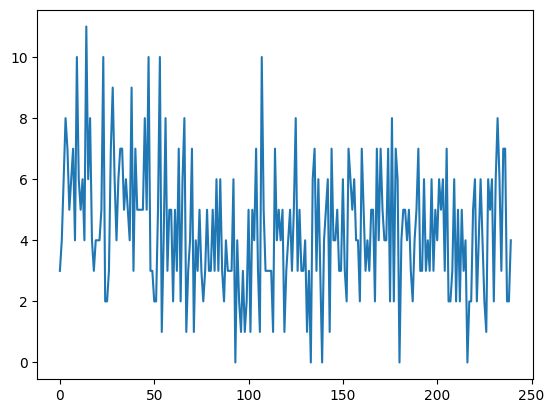

In [313]:
fig, ax = plt.subplots()
ax.plot(events_by_time)